## The Big Project begins!!

# "THE PRICE IS RIGHT" Capstone Project

This week - build a model that predicts how much something costs from a description, based on a scrape of Amazon data

# Order of play

DAY 1: Data Curation  
DAY 2: Data Pre-processing  
DAY 3: Evaluation, Baselines, Traditional ML  
DAY 4: Deep Learning and LLMs  
DAY 5: Fine-tuning a Frontier Model  

## DAY 1: Data Curation

Today we'll scrub our dataset and curate our data

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#181;">Business value of Data Curation</h2>
            <span style="color:#181;">Data Curation can be considered the less glamorous work of a Data Scientist. I say that's nonsense!
            This is where the science happens - what could be more glamorous than that?! R&D with your
            dataset can often have a greater impact on performance than the fashionable 'hyper-parameter optimization' that we do later.
            So: prepare for Quality Time with Data Quality.</span>
        </td>
    </tr>
</table>

In [1]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
# Hugging Face library to load datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random

from pricer.items import Item
from pricer.parser import parse
load_dotenv(override=True)

True

In [2]:
# Log in to HuggingFace - if you get a "Note" about Environment variable being set, ignore it

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Load our dataset

In the next cell, we load in the dataset from huggingface.

If this gives you an error like "trust_remote_code is no longer supported", then please run this command in a new cell: `!uv add --upgrade datasets==3.6.0` and then restart the Kernel, and try again.

In [3]:
# load the dataset from huggingface to huggingface dataset object
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", trust_remote_code=True)

In [4]:
print(f"Number of Beauty product: {len(dataset):,}")

Number of Beauty product: 112,590


In [5]:
# Investigate a particular datapoint

dataset[60]


{'main_category': 'All Beauty',
 'title': 'Cosplay Short White Mix Pink Curly Party for Women Girls Synthetic Hair Natural Looking Wig',
 'average_rating': 3.8,
 'rating_number': 6,
 'features': [],
 'description': [],
 'price': 'None',
 'images': {'hi_res': ['https://m.media-amazon.com/images/I/51YXyCz09eL._SL1100_.jpg',
   'https://m.media-amazon.com/images/I/618WI3d4gFL._SL1000_.jpg',
   'https://m.media-amazon.com/images/I/61im2a0vDwL._SL1000_.jpg',
   'https://m.media-amazon.com/images/I/51tF99bzmOL._SL1100_.jpg'],
  'large': ['https://m.media-amazon.com/images/I/41g-rdWGQtL.jpg',
   'https://m.media-amazon.com/images/I/51AYKPAyT+L.jpg',
   'https://m.media-amazon.com/images/I/51993mrPFSL.jpg',
   'https://m.media-amazon.com/images/I/31AEbCIqcoL.jpg'],
  'thumb': ['https://m.media-amazon.com/images/I/41g-rdWGQtL._SS40_.jpg',
   'https://m.media-amazon.com/images/I/51AYKPAyT+L._SS40_.jpg',
   'https://m.media-amazon.com/images/I/51993mrPFSL._SS40_.jpg',
   'https://m.media-amazon.c

In [6]:

# What's the most expensive item?

max_price = 0
max_item = None

for datapoint in tqdm(dataset):
    try:
        price = float(datapoint["price"])
        if price > max_price:
            max_item = datapoint
            max_price = price
    except ValueError:
        pass

print(f"The most expensive item is {max_item['title']} and it costs {max_price:,.2f}")

  0%|          | 0/112590 [00:00<?, ?it/s]

The most expensive item is Standing Power Body Lift (Lumex Easy Lift STS -LF2020) w/(FREE Sit to Stand Padded Sling - Large, DSLSA3 - 400lb 36"- 59") and it costs 2,548.98


In [7]:
# WHat is the cheapest item?
min_price = float('inf')
min_item = None
for datapoint in tqdm(dataset):
    try:
        price = float(datapoint["price"])
        if price < min_price:
            min_item = datapoint
            min_price = price
    except ValueError:
        pass
print(f"The cheapest item is priced at ${min_price:.2f}")
print(min_item)

  0%|          | 0/112590 [00:00<?, ?it/s]

The cheapest item is priced at $0.01
{'main_category': 'All Beauty', 'title': "Children's Hairpin Decorative Bow Headdress Hairpin Horsetail Clip", 'average_rating': 5.0, 'rating_number': 1, 'features': [], 'description': [], 'price': '0.01', 'images': {'hi_res': ['https://m.media-amazon.com/images/I/71RV0k4d4eL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/71RV0k4d4eL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/71H7ms+9DDL._SL1500_.jpg', 'https://m.media-amazon.com/images/I/7185SXpD76L._SL1500_.jpg', 'https://m.media-amazon.com/images/I/81286GG8E9L._SL1500_.jpg', 'https://m.media-amazon.com/images/I/81NDCazmFYL._SL1500_.jpg'], 'large': ['https://m.media-amazon.com/images/I/41pPRmz9IpL.jpg', 'https://m.media-amazon.com/images/I/41pPRmz9IpL.jpg', 'https://m.media-amazon.com/images/I/51e90VIK4nL.jpg', 'https://m.media-amazon.com/images/I/51Br6Hyqs0L.jpg', 'https://m.media-amazon.com/images/I/51mNxb3KtCL.jpg', 'https://m.media-amazon.com/images/I/615ixak7-BL.jpg'], 'thumb': 

This is the closest I can find - looks like it's going at a bargain price!!

https://www.amazon.com/TurboChef-Electric-Countertop-Microwave-Convection/dp/B01D05U9NO/

In [8]:
# Load into Item objects if they have a price range $1-$1000 and enough details

items = [parse(datapoint, "Beauty") for datapoint in tqdm(dataset)]
# remove None items
items = [item for item in items if item is not None]
print(f"There are {len(items):,} items from {len(dataset):,} datapoints")

  0%|          | 0/112590 [00:00<?, ?it/s]

There are 5,740 items from 112,590 datapoints


In [9]:
items[0].category


'Beauty'

In [10]:
print(items[0].full)

Lurrose 100Pcs Full Cover Fake Toenails Artificial Transparent Nail Tips Nail Art for DIY
['Description', 'The false toenails are durable with perfect length. You have the option to wear them long or clip them short, easy to trim and file them to in any length and shape you like. Plus, ABS is kind of green enviromental material, and makes the nails durable, breathable, light even no pressure on your own toenails. Fit well to your natural toenails. Non toxic, no smell, no harm to your health.', 'Feature', '- Color: As Shown.- Material: ABS.- Size: 14.3 x 7.2 x 1cm.', 'Package Including', '100 x Pieces fake toenails']
['The false toenails are durable with perfect length. You have the option to wear them long or clip them short, easy to trim and file them to in any length and shape you like.', 'ABS is kind of green enviromental material, and makes the nails durable, breathable, light even no pressure on your own nails.', 'Fit well to your natural toenails. Non toxic, no smell, no harm to 

In [11]:
prices = [item.price for item in items]
lengths = [len(item.full) for item in items]

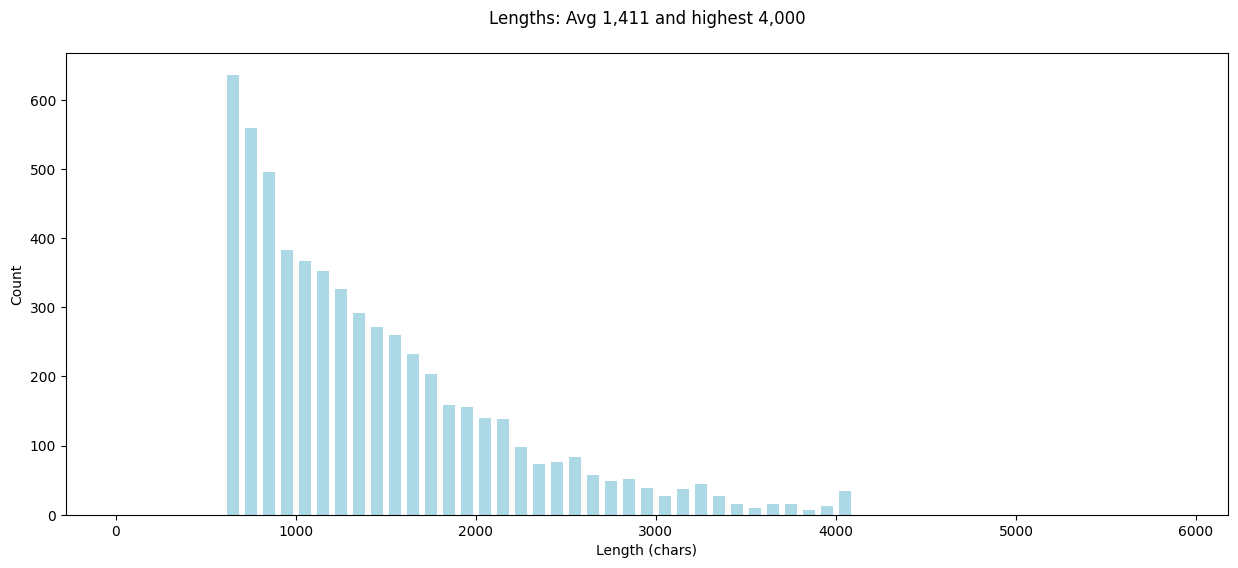

In [12]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

In [13]:
max_length = max(lengths)
max_length_item = items[lengths.index(max_length)]
print(max_length_item.full)


Manicure Kit Nail Clippers Set Professional Pedicure 15 Piece Black Stainless Steel Makeup Grooming Set Cutter Ear Pick Tweezers Scissors Nail file Gift for Man & Women (black/navy_15in1)…
['Professional Manicure pedicure kit & nail clippers set, grooming kit-15 pieces are the best product with luxurious travel case.', "The Best Manicure Set: Professional manicure tool set 15 in 1. All tools are made of high-quality stainless steel, sharp and durable, portable, comfortable to use and never rust to protect your health. black manicure set nail clippers set fingernail cutters nail scissors.Multi-Functional Nail Kit: These professional Manicure Kit Contains 16 pieces in for three functions including hand care(for fingernail part), facial care(for facial and brow trim part), and foot care (for Toenails part). The manicure pedicure set meet all you need. nail clippers set fingernail black manicure set cutters nail scissors.Easy to Use, Better Design: Our nail kit, highlight black tools with 

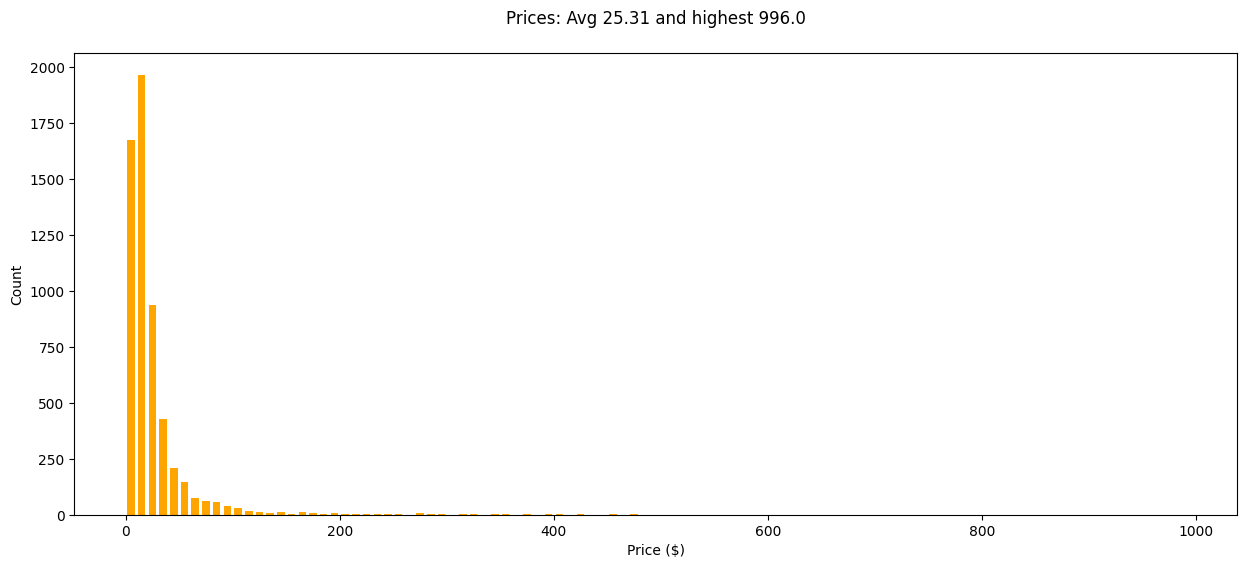

In [14]:
# Plot the distribution of prices
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [15]:
print(items[3].full)

Garnier Fructis Color Sealer, Instant, Lightweight Leave-In, Color Shield, For Color-Treated Hair, 6 oz.
['Proven to stop dry-out. Fight fade-out. The lightweight formula, infused with acai berry and grape seed oil, instantly seals in color for longer-lasting vibrancy while improving manageability and delivering lasting softness. Uva and uvb protectant help protect hair. Garnier fructis color shield instant color sealer lightweight leave-in instantly seals in color and conditions for extra softness.']
['Seals In Color And Conditions For Extra Softness', 'Infused With Acai Berry And Grape Seed Oil', 'For Color Treated Hair', 'Lightweight Formula']
{"Is Discontinued By Manufacturer": "No", "Product Dimensions": "1.35 x 2.39 x 6.63 inches; 7 Ounces", "UPC": "", "Manufacturer": "Garnier LLC"}


In [16]:
from pricer.loaders import ItemLoader
loader = ItemLoader("Appliances")
items = loader.load()


Loading dataset Appliances


100%|██████████| 95/95 [00:03<00:00, 29.35it/s]



Completed Appliances with 35,307 datapoints in 0.1 mins


In [29]:

# dataset_names = [
#     "Automotive",
#     "Electronics",
#     "Office_Products",
#     "Tools_and_Home_Improvement",
#     "Cell_Phones_and_Accessories",
#     "Toys_and_Games",
#     "Appliances",
#     "Musical_Instruments",
# ]

dataset_names = [
    "Appliances",
    "All_Beauty"
]

In [30]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Appliances


100%|██████████| 95/95 [00:03<00:00, 27.52it/s]



Completed Appliances with 35,307 datapoints in 0.1 mins
Loading dataset All_Beauty
Loading dataset All_Beauty


100%|██████████| 113/113 [00:02<00:00, 44.20it/s]



Completed All_Beauty with 5,740 datapoints in 0.1 mins


In [31]:
print(f"A grand total of {len(items):,} items")

A grand total of 41,047 items


In [33]:
items[102].category

'Appliances'

In [34]:
random.seed(42)
random.shuffle(items)

seen = set()
items = [x for x in tqdm(items) if not (x.title in seen or seen.add(x.title))]

seen = set()
items = [x for x in tqdm(items) if not (x.full in seen or seen.add(x.full))]

del seen
print(f"After deduplication, we have {len(items):,} items")

  0%|          | 0/41047 [00:00<?, ?it/s]

  0%|          | 0/39297 [00:00<?, ?it/s]

After deduplication, we have 38,384 items


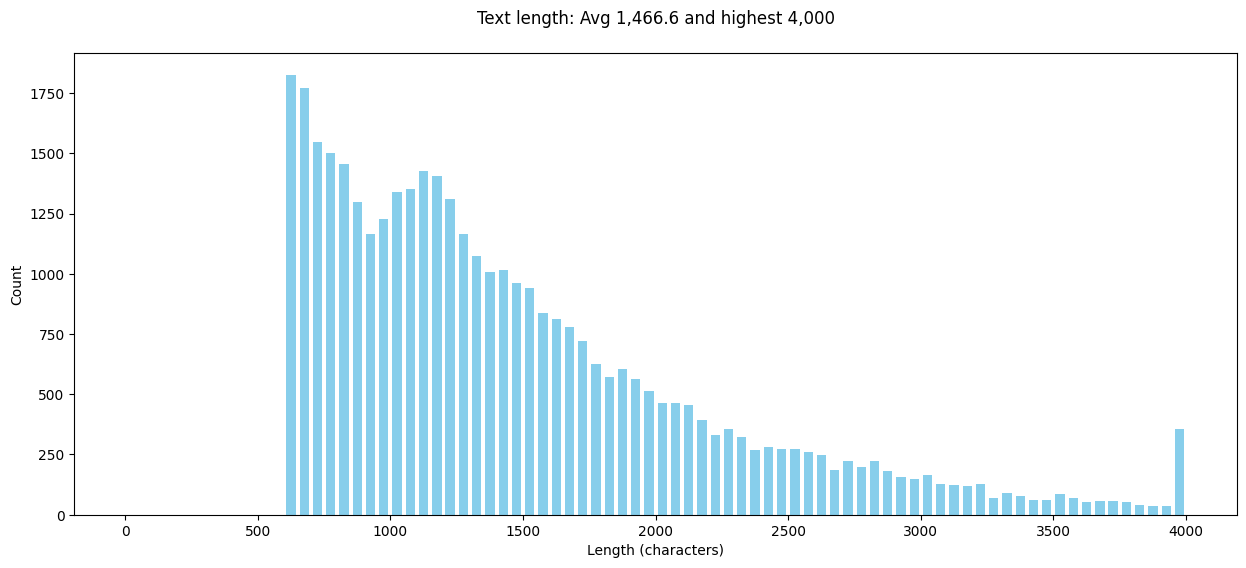

In [35]:
lengths = [len(item.full) for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Text length: Avg {sum(lengths)/len(lengths):,.1f} and highest {max(lengths):,}\n")
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="skyblue", bins=range(0, 4050, 50))
plt.show()

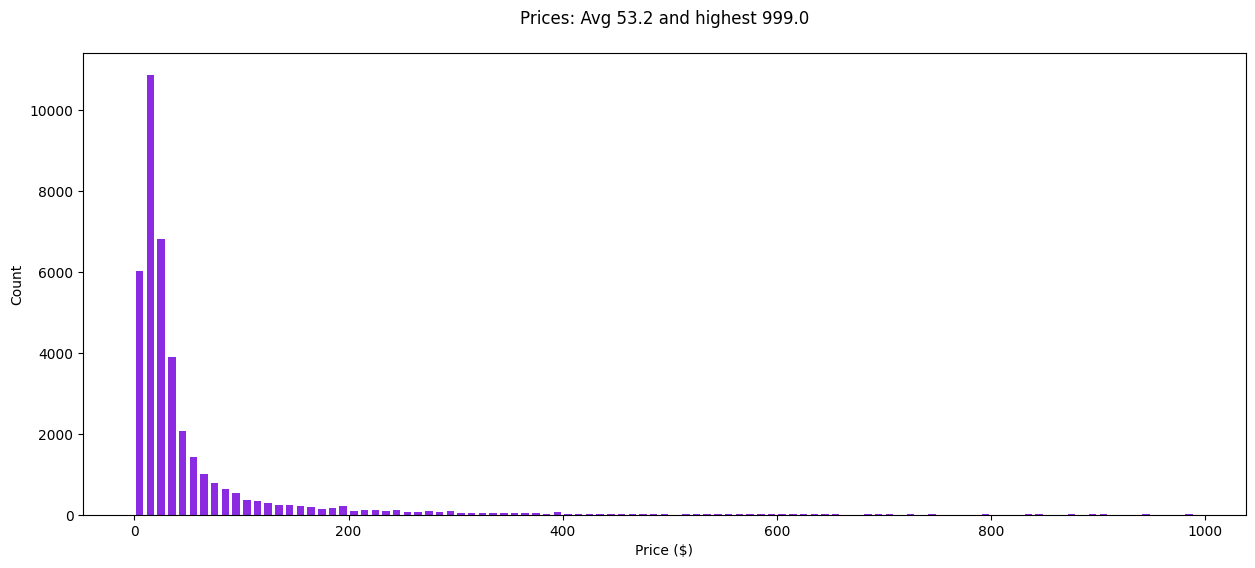

In [36]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

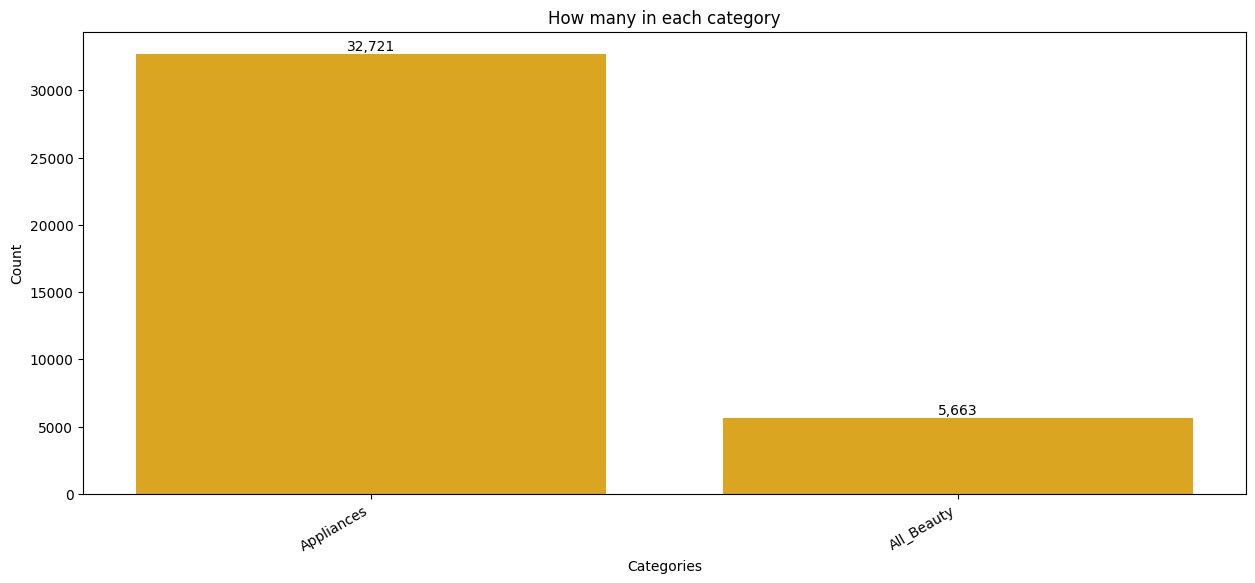

In [37]:
from collections import Counter
category_counts = Counter([item.category for item in items])

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

In [38]:
# Check how many items we have before sampling
print(f"Total items available: {len(items):,}")

Total items available: 38,384


In [40]:
np.random.seed(42)

# Adjust SIZE to not exceed available items
SIZE = min(820_000, len(items))
print(f"Sampling {SIZE:,} items from {len(items):,} available items")

prices = np.array([it.price for it in items], dtype=float)
categories = np.array([it.category for it in items])
p = (prices - prices.min()) / (prices.max() - prices.min() + 1e-9)

w = p**2
w[categories == "Tools_and_Home_Improvement"] *= 0.5
w[categories == "Automotive"] *= 0.05

# Add a small minimum weight to ensure all items can be sampled
w = w + 1e-6
w = w / w.sum()

# Count non-zero weights
non_zero_count = np.count_nonzero(w)
print(f"Non-zero weights: {non_zero_count:,}")

if SIZE > non_zero_count:
    print(f"Adjusting SIZE from {SIZE:,} to {non_zero_count:,} due to weight constraints")
    SIZE = non_zero_count

idx = np.random.choice(len(items), size=SIZE, replace=False, p=w)
sample = [items[i] for i in idx]

Sampling 38,384 items from 38,384 available items
Non-zero weights: 38,384


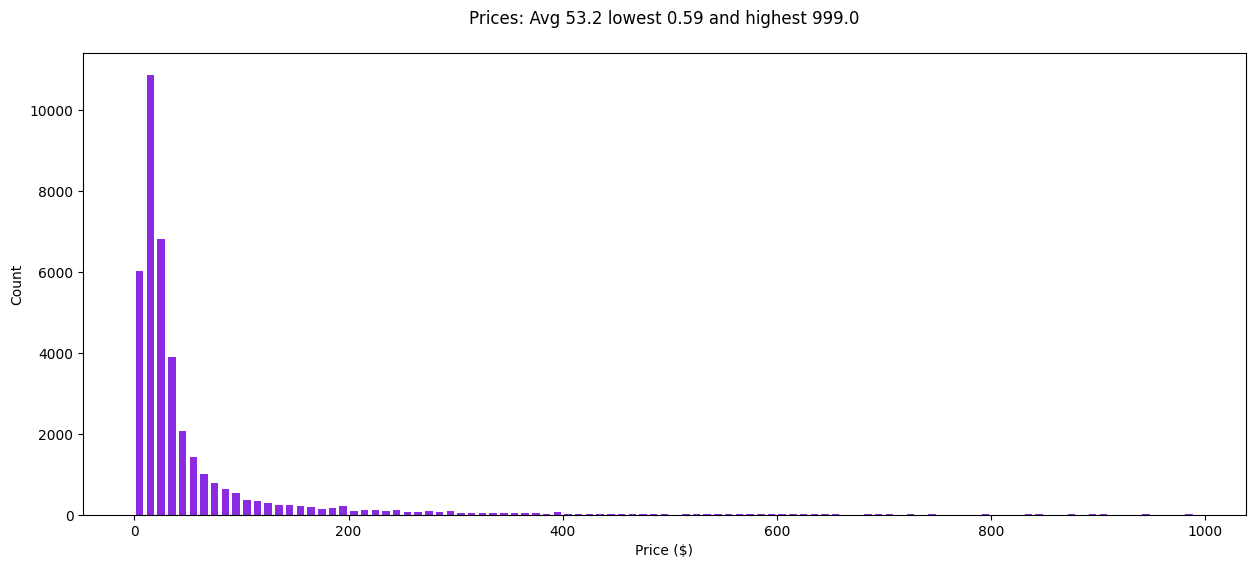

In [41]:
prices = [item.price for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} lowest {min(prices):,} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

In [ ]:
# Just for good measure, let's shuffle the sample again for the final dataset

random.seed(42)
# 42 is customary number for seeding
random.shuffle(sample)


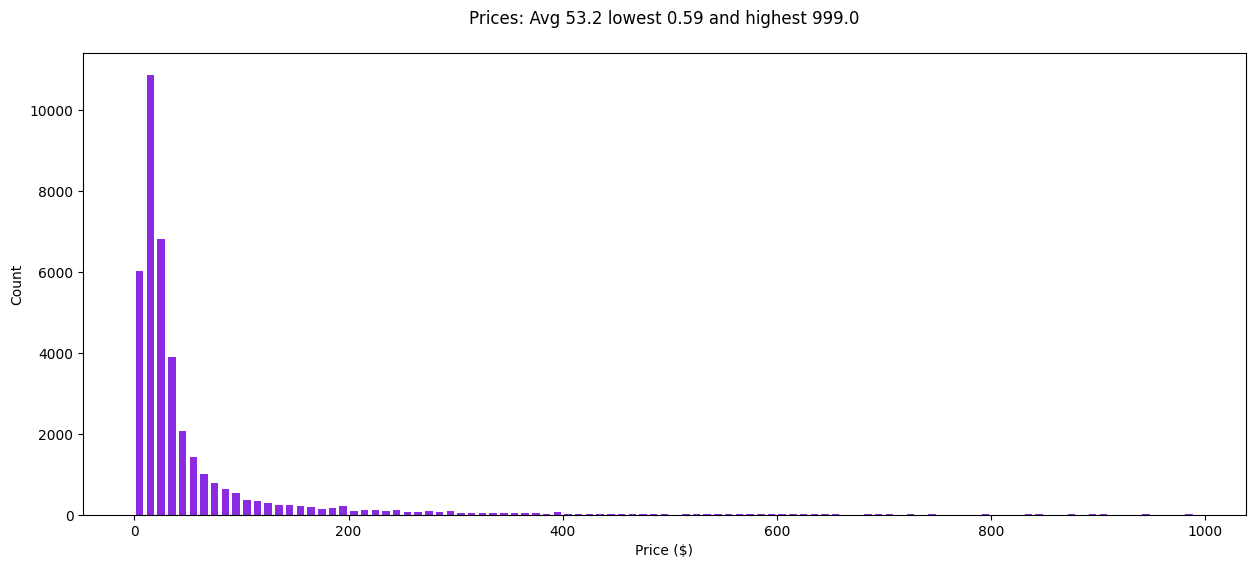

In [43]:
prices = [item.price for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} lowest {min(prices):,} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

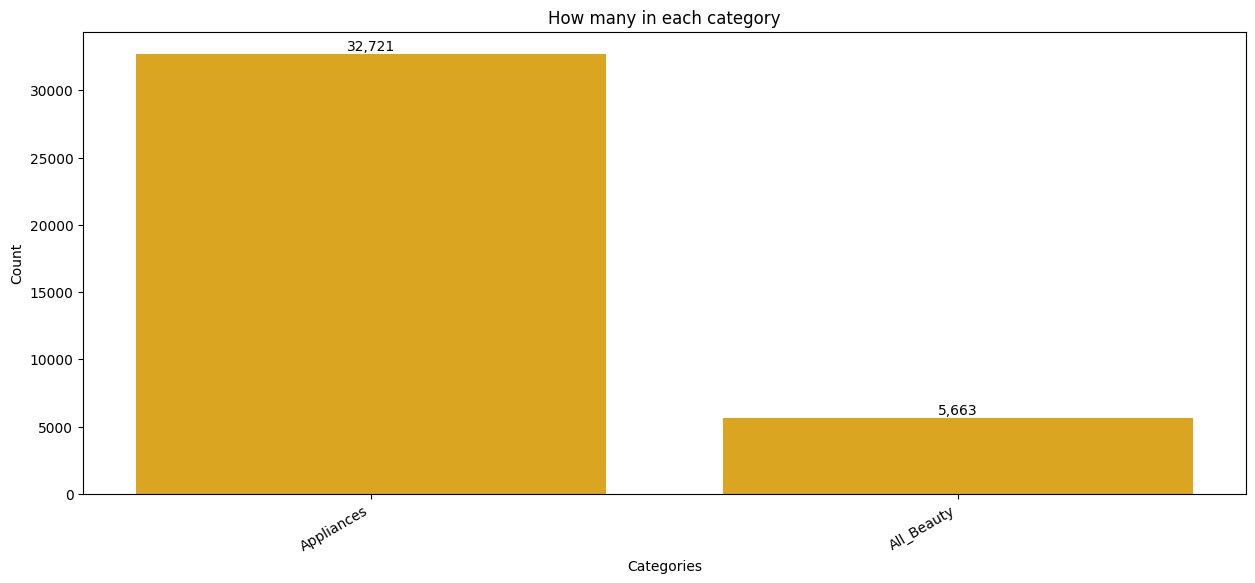

In [44]:
from collections import Counter
category_counts = Counter([item.category for item in sample])

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

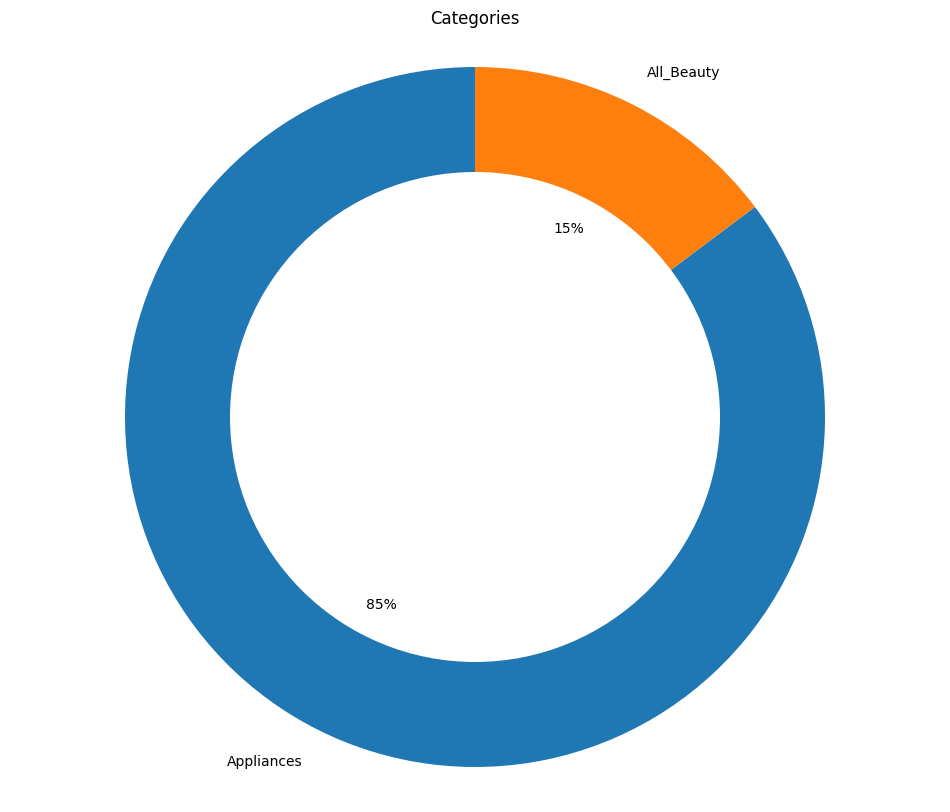

In [45]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

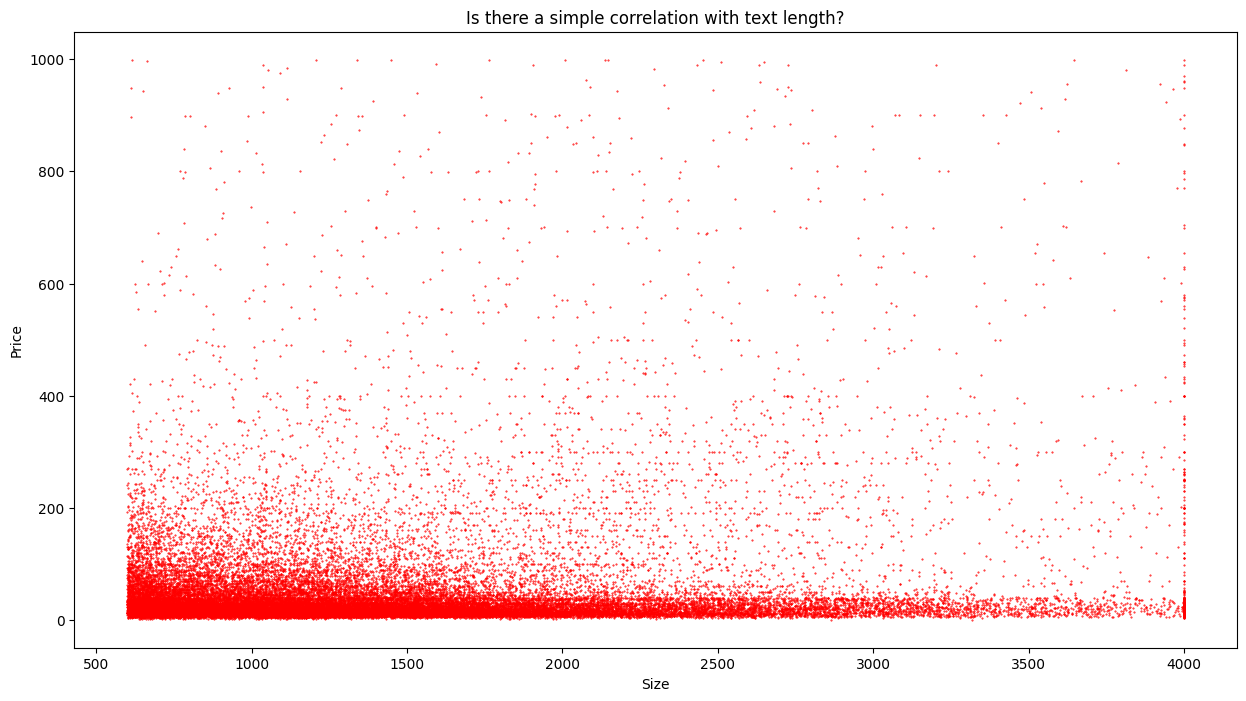

In [47]:
# How does the price vary with the character count?

sizes = [len(item.full) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation with text length?')

# Display the plot
plt.show()

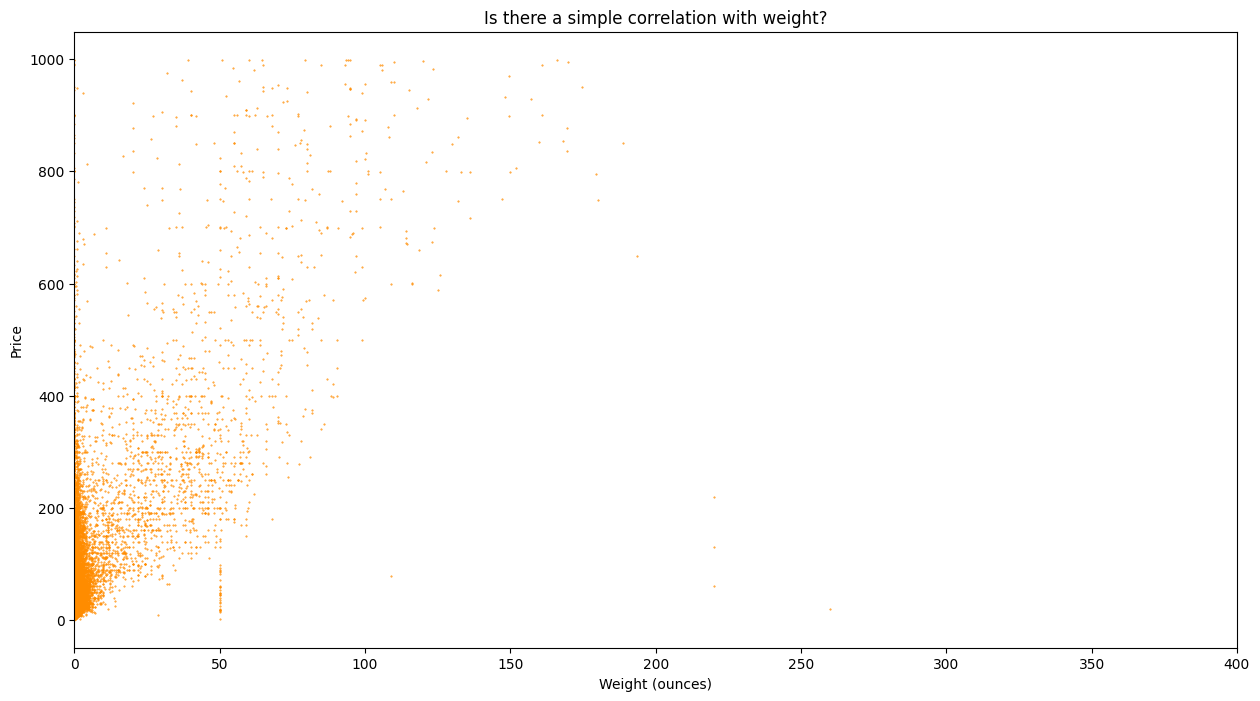

In [46]:
# How does the price vary with the weight?

ounces = [item.weight for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(ounces, prices, s=0.2, color="darkorange")

# Add labels and title
plt.xlabel('Weight (ounces)')
plt.ylabel('Price')
plt.xlim(0, 400)
plt.title('Is there a simple correlation with weight?')

# Display the plot
plt.show()

## Now push this dataset to the HuggingFace Hub

Replace the username with your HF username if you've crafted your own dataset

Or, ignore this cell and you can load my dataset tomorrow!

In [ ]:
username = "ed-donner"
full = f"{username}/items_raw_full"
lite = f"{username}/items_raw_lite"

train = sample[:800_000]
val = sample[800_000:810_000]
test = sample[810_000:]

Item.push_to_hub(full, train, val, test)

train_lite = train[:20_000]
val_lite = val[:1_000]
test_lite = test[:1_000]

Item.push_to_hub(lite, train_lite, val_lite, test_lite)

## Sidenote

If you like the variety of colors that matplotlib can use in its charts, you should bookmark this:

https://matplotlib.org/stable/gallery/color/named_colors.html
